In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from scipy.stats import kendalltau

In [14]:
imagery_root_dir = Path('../../../data/Streamflow/fpe_stations')
results_root_dir = Path('../results/vary_annot_frac.kernighan-lin_test')

site = 'West Brook 0_01171100'
# site = 'Sanderson Brook_01171010'
site_imagery_dir = imagery_root_dir / site / 'FLOW_CFS'
# load results
results_dir = results_root_dir / f'{site}-pairs-train' / 'inference' / 'inference_ranking_model_1' / 'inference_results_images.csv'
results = pd.read_csv(results_dir)
# drop rows containing NaN values in "value" or "scores" columns
results = results.dropna(subset=['value', 'scores'])
# convert 'timestamp' column to datetime
results['timestamp'] = pd.to_datetime(results['timestamp'])
results = results.sort_values('timestamp')
# # drop rows whose 'timestamp' is before 7am or after 7pm
# results = results[results['timestamp'].dt.hour.between(7, 19)]

# compute kendall tau between 'value' and 'scores' columns
tau, p_value = kendalltau(results['value'], results['scores'])
print(f'Kendall tau: {tau}, p-value: {p_value}')

Kendall tau: 0.7809783504027705, p-value: 0.0


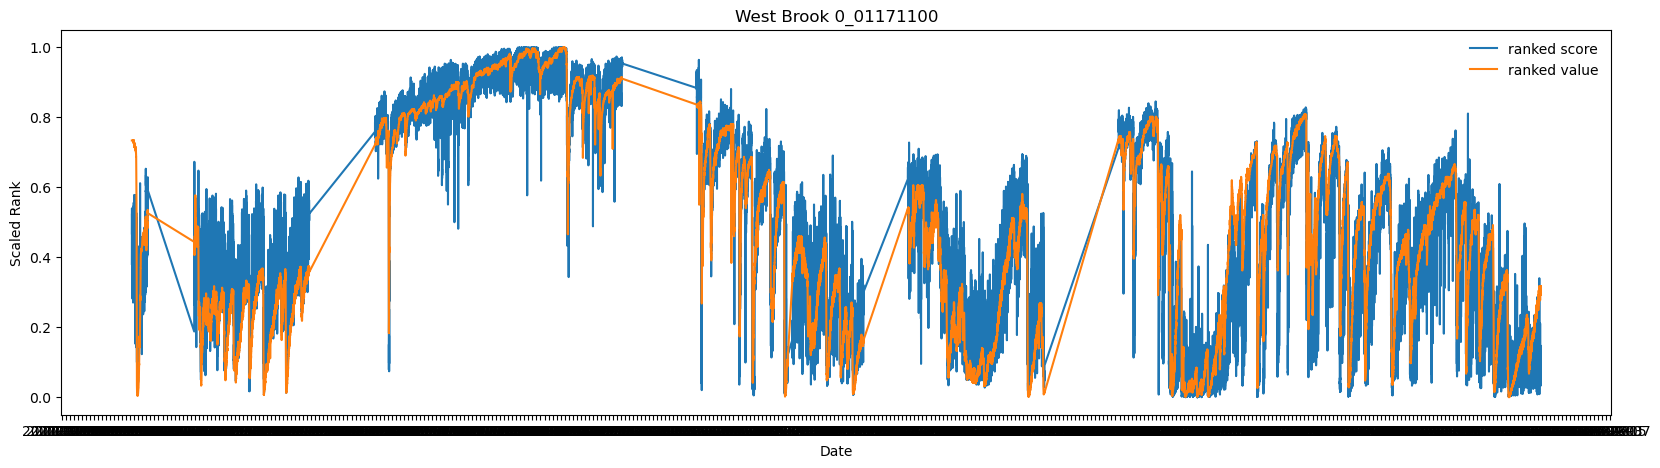

In [15]:
# create columns for ranked value and ranked score
results['ranked_value'] = results['value'].rank(ascending=False) / len(results)
results['ranked_score'] = results['scores'].rank(ascending=False) / len(results)

# # sanity check: compute kendall tau between 'ranked_value' and 'ranked_score' columns
# tau, p_value = kendalltau(results['ranked_value'], results['ranked_score'])
# print(f'Kendall tau: {tau}, p-value: {p_value}')

# plot the ranked value and ranked score over time
plt.figure(figsize=(20, 5))
plt.plot(results['timestamp'], results['ranked_score'], label='ranked score')
plt.plot(results['timestamp'], results['ranked_value'], label='ranked value')

# limit the x-axis to between 2022-04-01 and 2022-05-31
# plt.xlim(pd.Timestamp('2022-04-01'), pd.Timestamp('2022-10-01'))
# plt.xlim(pd.Timestamp('2022-04-01'), pd.Timestamp('2022-5-01'))
# plt.xlim(pd.Timestamp('2022-07-01'), pd.Timestamp('2022-8-01'))

# format the x-axis to display the dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))

plt.legend(frameon=False)
plt.xlabel('Date')
plt.ylabel('Scaled Rank')
plt.title(site)
plt.show()


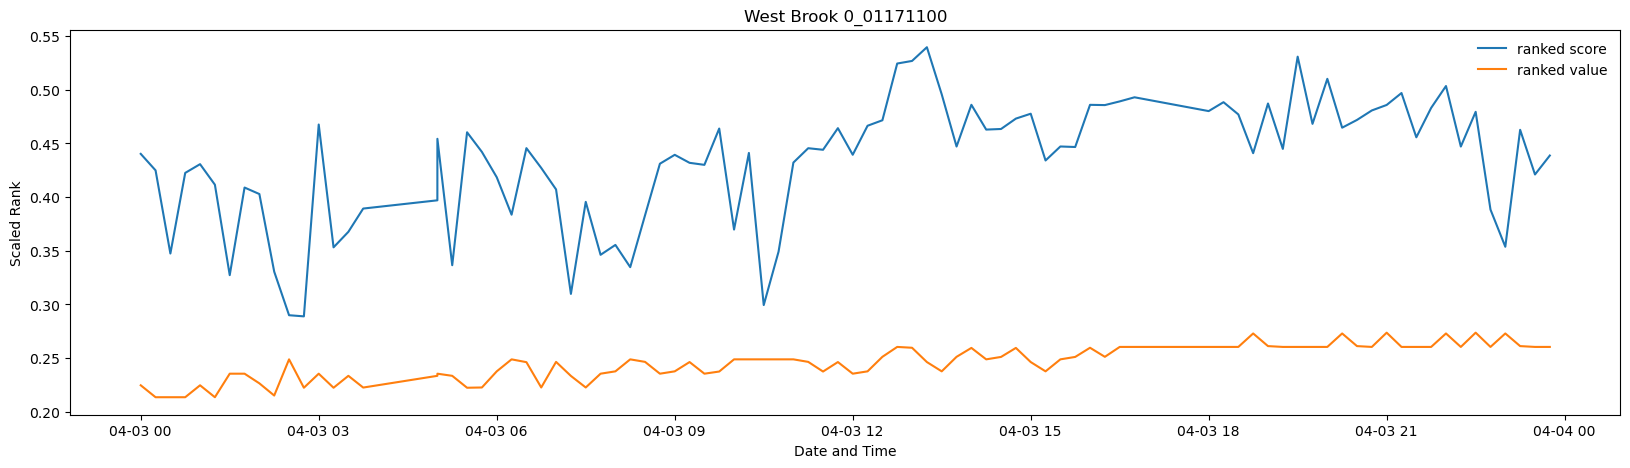

In [16]:
# results for just 1 date
results_2022_04_01 = results[results['timestamp'].dt.date == pd.Timestamp('2022-04-03').date()]
results_2022_04_01.head(10)
# plot the ranked value and ranked score for 2022-04-01
plt.figure(figsize=(20, 5))
plt.plot(results_2022_04_01['timestamp'], results_2022_04_01['ranked_score'], label='ranked score')
plt.plot(results_2022_04_01['timestamp'], results_2022_04_01['ranked_value'], label='ranked value')
plt.legend(frameon=False)
plt.xlabel('Date and Time')
plt.ylabel('Scaled Rank')
plt.title(site)
plt.show()

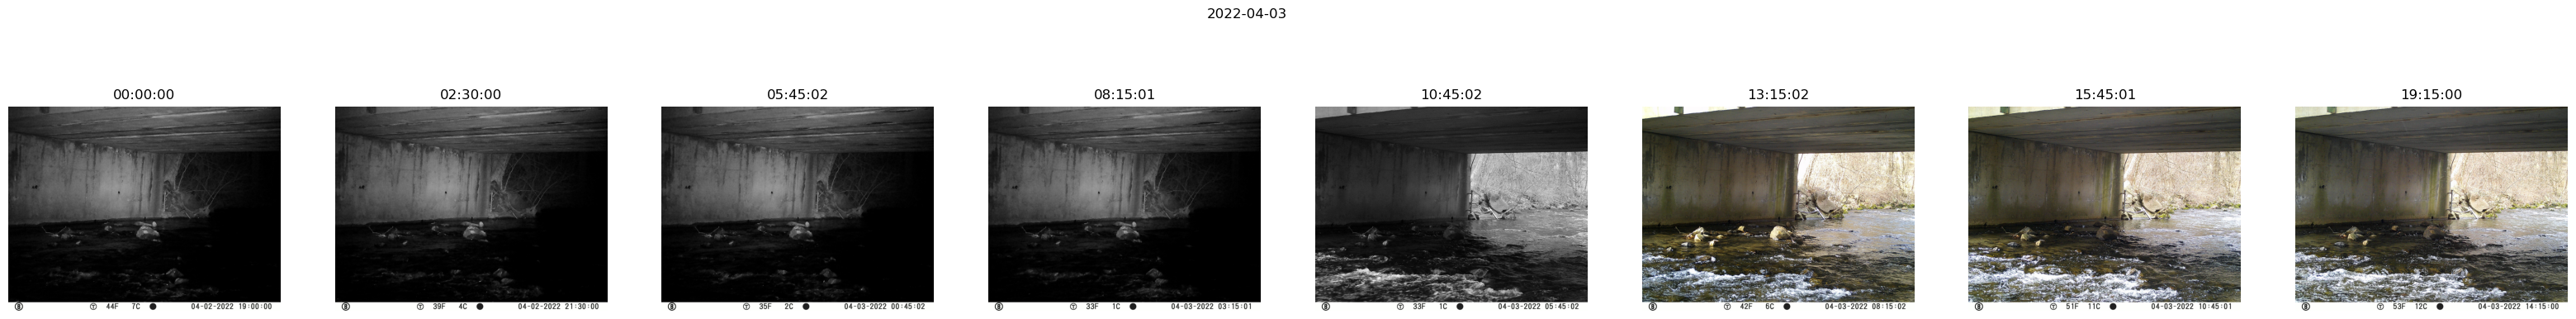

In [17]:
# plot every 8th image
num_images = len(results_2022_04_01)
num_subplots = num_images // 10
fig, axs = plt.subplots(1, num_subplots, figsize=(5 * num_subplots, 5))
for i, ax in enumerate(axs):
    image_path = site_imagery_dir / results_2022_04_01.iloc[i * 10]['filename']
    image = plt.imread(image_path)
    ax.imshow(image)
    # put timestamp time as title
    ax.set_title(results_2022_04_01.iloc[i * 10]['timestamp'].time())
    ax.axis('off')
# put the date as the figure title
fig.suptitle(results_2022_04_01.iloc[0]['timestamp'].date())
plt.show()


In [18]:
# group by date and compute mean and std of daily ranked value and ranked score
results['date'] = results['timestamp'].dt.date
results['date'] = pd.to_datetime(results['date'])
results_grouped = results.groupby('date').agg({'ranked_value': ['mean', 'std'], 'ranked_score': ['mean', 'std']})
results_grouped.index = pd.to_datetime(results_grouped.index)
results_grouped.columns = ['ranked_value_mean', 'ranked_value_std', 'ranked_score_mean', 'ranked_score_std']
results_grouped.head(10)

ranked_value_mean  ranked_value_std  ranked_score_mean  \
date                                                                 
2022-02-01           0.733628          0.000000           0.463785   
2022-02-02           0.731522          0.004429           0.430640   
2022-02-03           0.706517          0.016741           0.462538   
2022-02-04           0.109065          0.196748           0.140656   
2022-02-05           0.135903          0.077384           0.256891   
2022-02-06           0.386471          0.044462           0.333571   
2022-02-07           0.465559          0.007382           0.334616   
2022-02-08           0.472580          0.024792           0.447483   
2022-02-09           0.490995          0.028355           0.478134   
2022-03-04           0.425703          0.009590           0.399175   

            ranked_score_std  
date                          
2022-02-01          0.061505  
2022-02-02          0.094005  
2022-02-03          0.074741  
2022-02-04          0.111786  
2022-02-05          0.085371  
2022-02-06          0.072241  
2022-02-07          0.067841  
2022-02-08          0.106641  
2022-02-09          0.083726  
2022-03-04          0.132523

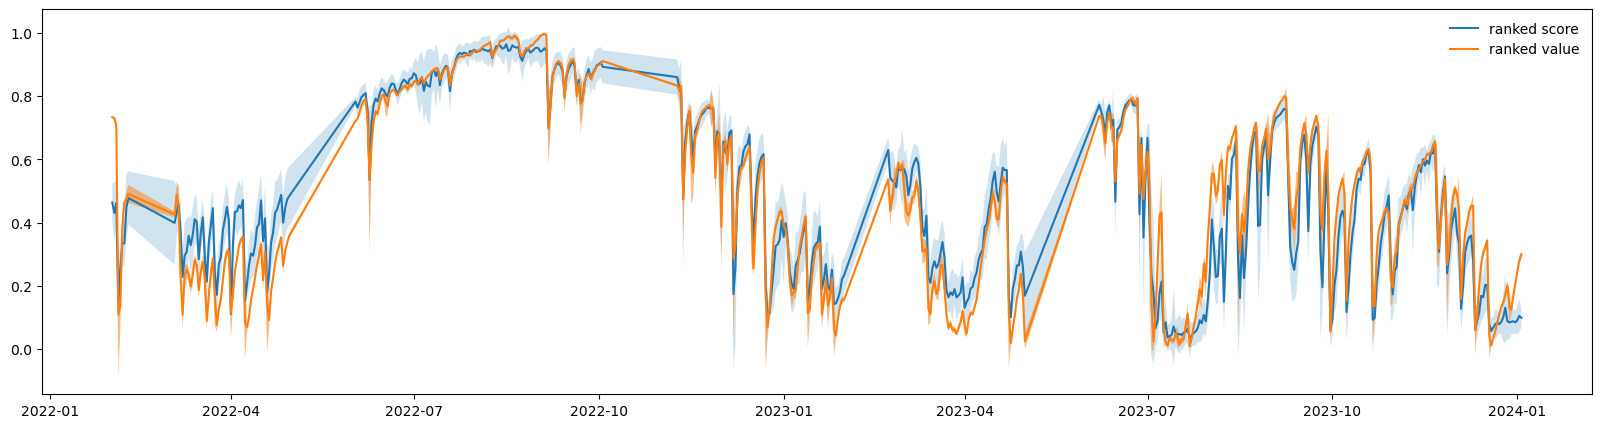

In [19]:
# plot daily mean ranked value and ranked score
plt.figure(figsize=(20, 5))
plt.plot(results_grouped.index, results_grouped['ranked_score_mean'], label='ranked score')
plt.fill_between(results_grouped.index, results_grouped['ranked_score_mean'] - results_grouped['ranked_score_std'],
                 results_grouped['ranked_score_mean'] + results_grouped['ranked_score_std'], alpha=0.2)
plt.plot(results_grouped.index, results_grouped['ranked_value_mean'], label='ranked value')
plt.fill_between(results_grouped.index, results_grouped['ranked_value_mean'] - results_grouped['ranked_value_std'],
                 results_grouped['ranked_value_mean'] + results_grouped['ranked_value_std'], alpha=0.5)
plt.legend(frameon=False)
plt.show()


In [20]:
# get absolute valued difference between daily mean ranked value and ranked score
results_grouped['abs_diff_mean'] = np.abs(results_grouped['ranked_value_mean'] - results_grouped['ranked_score_mean'])

# get absolute valued difference between daily mean ranked value and ranked score
results_grouped['abs_diff_std'] = np.abs(results_grouped['ranked_value_std'] - results_grouped['ranked_score_std'])

display(results_grouped.sort_values('abs_diff_mean', ascending=False).head(10))
display(results_grouped.sort_values('abs_diff_std', ascending=False).head(10))

ranked_value_mean  ranked_value_std  ranked_score_mean  \
date                                                                 
2022-02-02           0.731522          0.004429           0.430640   
2023-08-08           0.424623          0.041392           0.149552   
2022-02-01           0.733628          0.000000           0.463785   
2023-08-05           0.500587          0.029583           0.230790   
2023-08-04           0.484974          0.026747           0.228075   
2023-08-09           0.554671          0.031624           0.306604   
2023-07-07           0.424318          0.040091           0.177653   
2022-02-03           0.706517          0.016741           0.462538   
2023-08-03           0.553652          0.026773           0.325820   
2023-08-06           0.582035          0.013409           0.357106   

            ranked_score_std  abs_diff_mean  abs_diff_std  
date                                                       
2022-02-02          0.094005       0.300882      0.089576  
2023-08-08          0.090390       0.275071      0.048998  
2022-02-01          0.061505       0.269843      0.061505  
2023-08-05          0.082912       0.269798      0.053329  
2023-08-04          0.087944       0.256899      0.061197  
2023-08-09          0.102763       0.248067      0.071139  
2023-07-07          0.084146       0.246666      0.044055  
2022-02-03          0.074741       0.243979      0.057999  
2023-08-03          0.131581       0.227832      0.104808  
2023-08-06          0.087085       0.224929      0.073676

ranked_value_mean  ranked_value_std  ranked_score_mean  \
date                                                                 
2023-07-04           0.024099          0.027974           0.177943   
2022-12-08           0.330697          0.073190           0.257072   
2023-07-02           0.519137          0.145850           0.398823   
2023-06-29           0.474436          0.064180           0.352805   
2022-11-30           0.683627          0.063217           0.639132   
2023-01-01           0.390947          0.014655           0.354770   
2022-12-28           0.386869          0.010871           0.326026   
2022-12-30           0.434573          0.013819           0.345556   
2023-11-10           0.510398          0.012296           0.439624   
2022-03-04           0.425703          0.009590           0.399175   

            ranked_score_std  abs_diff_mean  abs_diff_std  
date                                                       
2023-07-04          0.226168       0.153844      0.198193  
2022-12-08          0.241984       0.073625      0.168794  
2023-07-02          0.312245       0.120314      0.166395  
2023-06-29          0.222926       0.121631      0.158746  
2022-11-30          0.208240       0.044496      0.145023  
2023-01-01          0.149946       0.036176      0.135291  
2022-12-28          0.145514       0.060843      0.134643  
2022-12-30          0.140232       0.089017      0.126413  
2023-11-10          0.137513       0.070773      0.125217  
2022-03-04          0.132523       0.026529      0.122934

Date with highest absolute difference between daily mean ranked value and ranked score: 2022-02-02


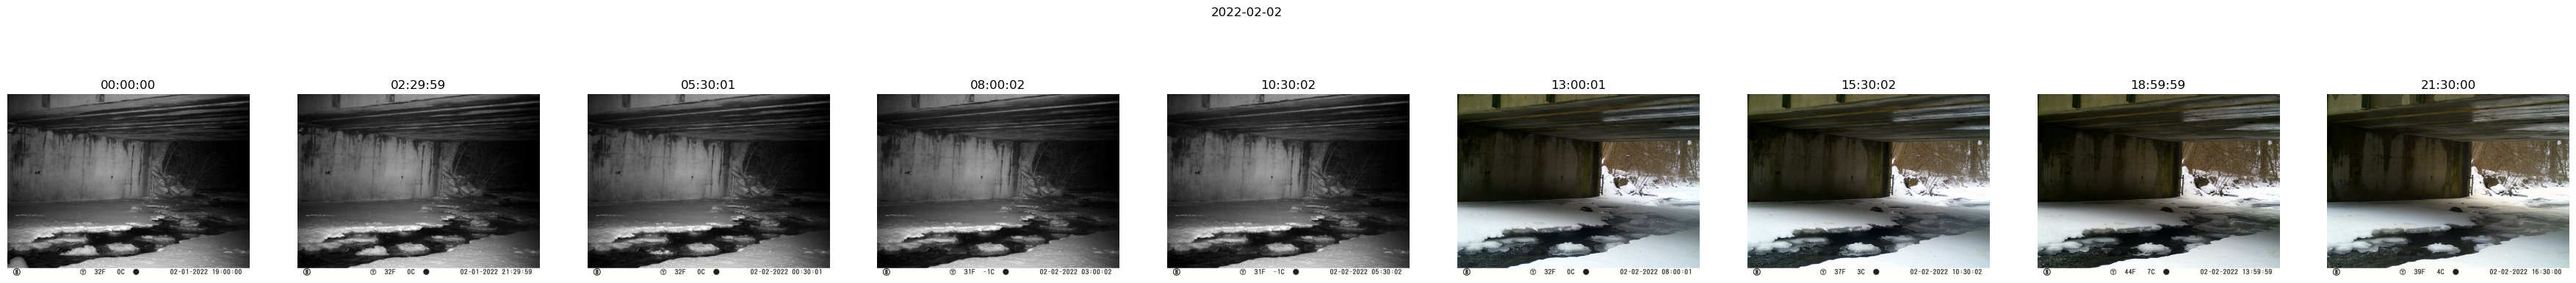

In [21]:
# for the date with the highest absolute difference between daily mean ranked value and ranked score
# plot every 10th image
results['date'] = results['timestamp'].dt.date
# date with highest absolute difference between daily mean ranked value and ranked score
date_highest_abs_diff_mean = results_grouped.sort_values('abs_diff_mean', ascending=False).index[0].date()
print(f'Date with highest absolute difference between daily mean ranked value and ranked score: {date_highest_abs_diff_mean}')
results_highest_abs_diff_mean = results[results['date'] == date_highest_abs_diff_mean]
num_images = len(results_highest_abs_diff_mean)
num_subplots = num_images // 10
fig, axs = plt.subplots(1, num_subplots, figsize=(5 * num_subplots, 5))
for i, ax in enumerate(axs):
    image_path = site_imagery_dir / results_highest_abs_diff_mean.iloc[i * 10]['filename']
    image = plt.imread(image_path)
    ax.imshow(image)
    # put timestamp time as title
    ax.set_title(results_highest_abs_diff_mean.iloc[i * 10]['timestamp'].time())
    ax.axis('off')
# put the date as the figure title
fig.suptitle(results_highest_abs_diff_mean.iloc[0]['timestamp'].date())
plt.show()

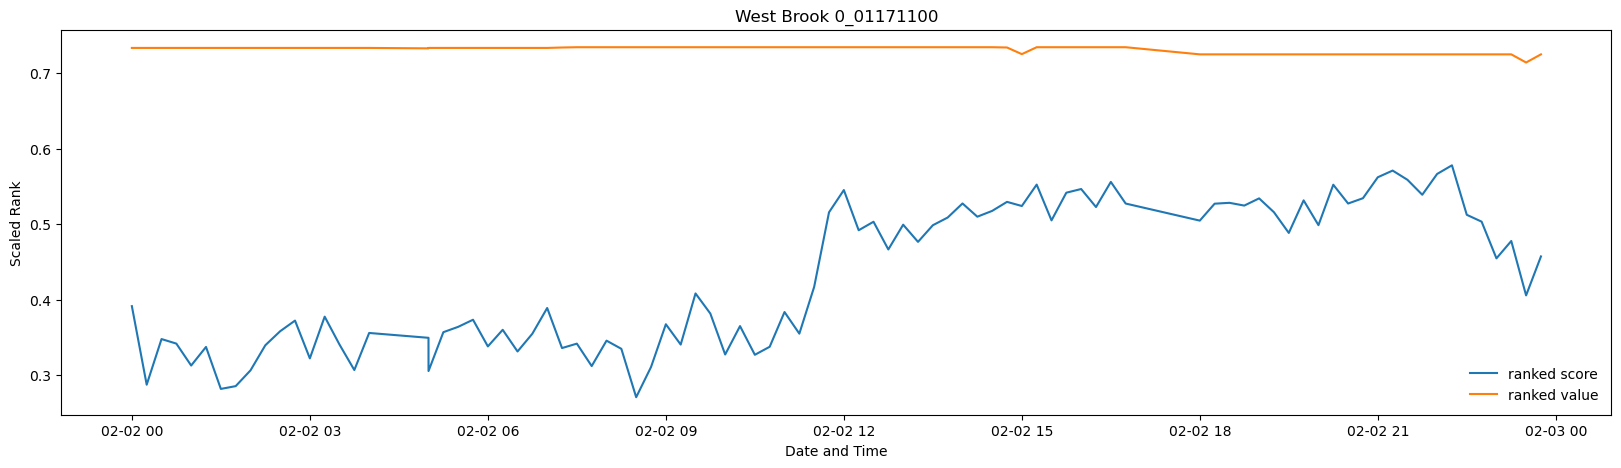

In [22]:
# results for just 1 date
plt.figure(figsize=(20, 5))
plt.plot(results_highest_abs_diff_mean['timestamp'], results_highest_abs_diff_mean['ranked_score'], label='ranked score')
plt.plot(results_highest_abs_diff_mean['timestamp'], results_highest_abs_diff_mean['ranked_value'], label='ranked value')
plt.legend(frameon=False)
plt.xlabel('Date and Time')
plt.ylabel('Scaled Rank')
plt.title(site)
plt.show()

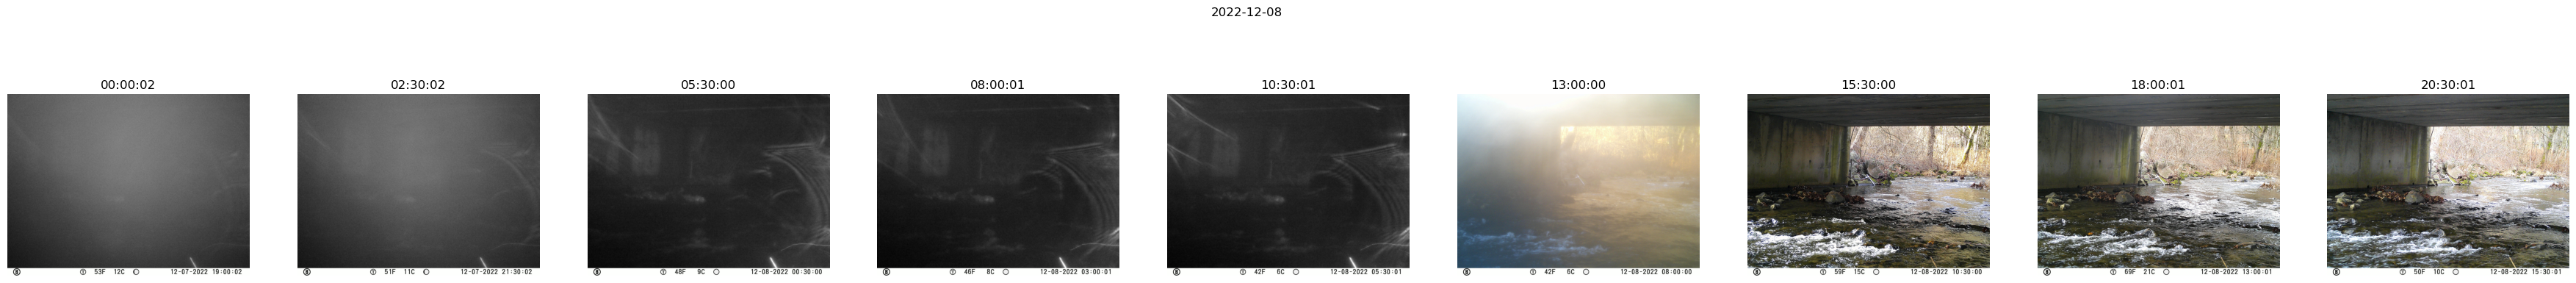

In [23]:
# for the date with the highest absolute difference between daily std ranked value and ranked score
# plot every 10th image
# date with highest absolute difference between daily mean ranked value and ranked score
date_highest_abs_diff_std = results_grouped.sort_values('abs_diff_std', ascending=False).index[1].date()
results_highest_abs_diff_std = results[results['date'] == date_highest_abs_diff_std]
num_images = len(results_highest_abs_diff_std)
num_subplots = num_images // 10
fig, axs = plt.subplots(1, num_subplots, figsize=(5 * num_subplots, 5))
for i, ax in enumerate(axs):
    image_path = site_imagery_dir / results_highest_abs_diff_std.iloc[i * 10]['filename']
    image = plt.imread(image_path)
    ax.imshow(image)
    # put timestamp time as title
    ax.set_title(results_highest_abs_diff_std.iloc[i * 10]['timestamp'].time())
    ax.axis('off')
# put the date as the figure title
fig.suptitle(results_highest_abs_diff_std.iloc[0]['timestamp'].date())
plt.show()


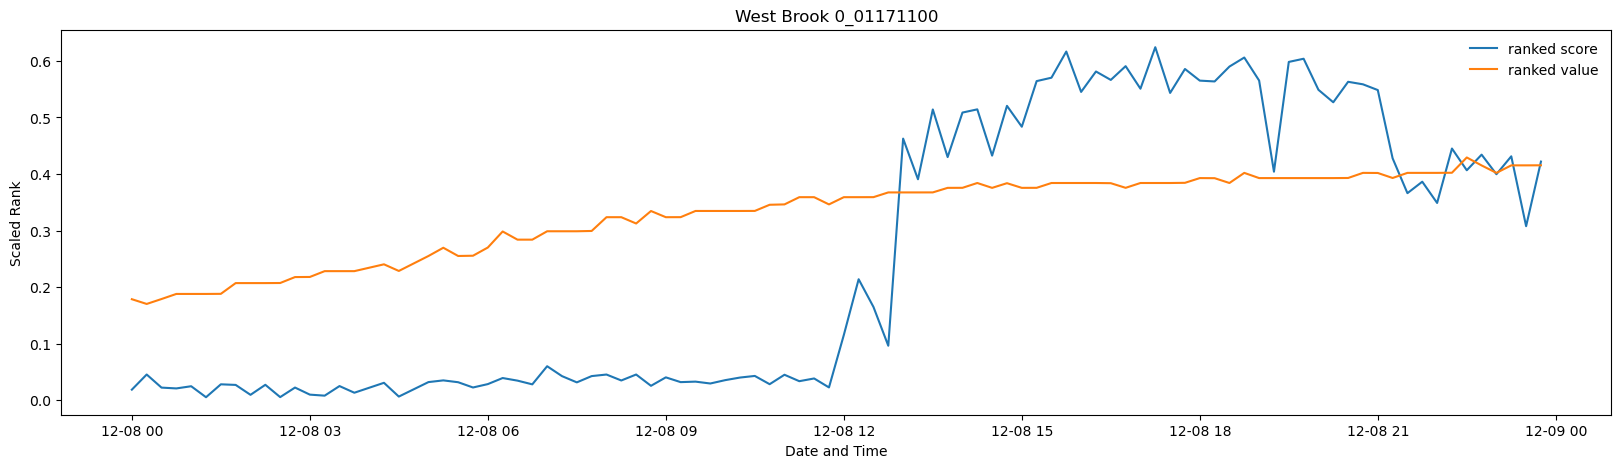

In [24]:
# results for just 1 date
plt.figure(figsize=(20, 5))
plt.plot(results_highest_abs_diff_std['timestamp'], results_highest_abs_diff_std['ranked_score'], label='ranked score')
plt.plot(results_highest_abs_diff_std['timestamp'], results_highest_abs_diff_std['ranked_value'], label='ranked value')
plt.legend(frameon=False)
plt.xlabel('Date and Time')
plt.ylabel('Scaled Rank')
plt.title(site)
plt.show()